In [43]:
import numpy as np
import pandas as pd
import tensorflow as ts
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM

from string import punctuation

Using TensorFlow backend.


In [12]:
df = pd.read_csv('dataset/newyork/ArticlesMay2017.csv', encoding='utf-8')

In [13]:
df.head()

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,5906b3197c459f24986dd003,2412,By IAN JOHNSON,article,My Beijing: The Sacred City,"['Travel and Vacations', 'Beijing (China)', 'R...",3,Travel,1,2017-05-01 04:01:21,Unknown,"This metropolis was once a total work of art, ...",The New York Times,News,https://www.nytimes.com/2017/05/01/travel/beij...
1,NaN,5906b3297c459f24986dd004,2318,By EMMA G. FITZSIMMONS,article,"6 Million Riders a Day, 1930s Technology","['Subways', 'Delays (Transportation)', 'Transi...",68,Metro,1,2017-05-01 04:01:33,Unknown,New York’s subway is struggling with old infra...,The New York Times,News,https://www.nytimes.com/2017/05/01/nyregion/ne...
2,NaN,5906ceec7c459f24986dd021,1795,By MARC TRACY,article,Seeking a Cross-Border Conference,"['Cetys University', 'College Athletics', 'Nat...",3,Sports,1,2017-05-01 06:00:05,Unknown,Cetys University is making an ambitious bid to...,The New York Times,News,https://www.nytimes.com/2017/05/01/sports/mexi...
3,NaN,5906cfa77c459f24986dd022,213,By SHANNON DOYNE,article,"Questions for: ‘Despite the “Yuck Factor,” Lee...",[],3,Learning,0,2017-05-01 06:03:03,Unknown,How are leeches used to treat various medical ...,The New York Times,News,https://www.nytimes.com/2017/05/01/learning/qu...
4,NaN,5906e1c07c459f24986dd039,1342,By JASON STANLEY,article,Who Is a ‘Criminal’?,"['Illegal Immigration', 'Traffic and Parking V...",3,OpEd,0,2017-05-01 07:20:26,Unknown,Justice Roberts was right. The Trump administr...,The New York Times,Op-Ed,https://www.nytimes.com/2017/05/01/opinion/who...


In [14]:
df.count()

abstract             33
articleID           996
articleWordCount    996
byline              996
documentType        996
headline            996
keywords            996
multimedia          996
newDesk             996
printPage           996
pubDate             996
sectionName         996
snippet             996
source              996
typeOfMaterial      996
webURL              996
dtype: int64

In [16]:
df['headline'].isnull().values.any()

False

In [40]:
cnt = 0
for i in df['headline']:
    if i == 'Unknown':
        cnt += 1

print("Unkown's data count :", cnt)

Unkown's data count : 61


In [17]:
headline = [title for title in df.headline.values]
headline[:5]

['My Beijing: The Sacred City',
 '6 Million Riders a Day, 1930s Technology',
 'Seeking a Cross-Border Conference',
 'Questions for: ‘Despite the “Yuck Factor,” Leeches Are Big in Russian Medicine’',
 'Who Is a ‘Criminal’?']

In [20]:
headline = [title for title in headline if title != 'Unknown']

In [21]:
headline

['My Beijing: The Sacred City',
 '6 Million Riders a Day, 1930s Technology',
 'Seeking a Cross-Border Conference',
 'Questions for: ‘Despite the “Yuck Factor,” Leeches Are Big in Russian Medicine’',
 'Who Is a ‘Criminal’?',
 'An Antidote to Europe’s Populism',
 'The Cost of a Speech',
 'Degradation of the Language',
 'On the Power of Being Awful',
 'Trump Garbles Pitch on a Revised Health Bill',
 'What’s Going On in This Picture? | May 1, 2017',
 'When Patients Hit a Medical Wall',
 'For Pregnant Women, Getting Serious About Whooping Cough',
 'New York City Transit Reporter in Wonderland: Riding the London Tube',
 'How to Cut an Avocado Without Cutting Yourself',
 'In Fictional Suicide, Health Experts Say They See a Real Cause for Alarm',
 'Claims of Liberal Media Bias Hit ESPN, Too',
 'Is the dream in Australia crumbling?',
 'Police in Texas Change Account in Officer’s Fatal Shooting of 15-Year-Old',
 'Most Adults Favor Sex Ed. Most Students Don’t Get It.',
 'Australia Feels Its Ties 

In [22]:
def repreprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    return ''.join(c for c in s if c not in punctuation).lower()

In [23]:
text = [repreprocessing(x) for x in headline]

In [24]:
text[:5]

['my beijing the sacred city',
 '6 million riders a day 1930s technology',
 'seeking a crossborder conference',
 'questions for despite the yuck factor leeches are big in russian medicine',
 'who is a criminal']

In [25]:
t = Tokenizer()

In [26]:
t.fit_on_texts(text)
vocab_size = len(t.word_index) + 1
vocab_size

2653

In [27]:
seqences = []
for line in text:
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        seqence = encoded[:i+1]
        seqences.append(seqence)
        
seqences[:11]

[[48, 799],
 [48, 799, 1],
 [48, 799, 1, 800],
 [48, 799, 1, 800, 57],
 [114, 406],
 [114, 406, 407],
 [114, 406, 407, 2],
 [114, 406, 407, 2, 179],
 [114, 406, 407, 2, 179, 801],
 [114, 406, 407, 2, 179, 801, 802],
 [803, 2]]

In [28]:
index_to_word = {}
for key, value in t.word_index.items():
    index_to_word[value] = key
    
index_to_word[1], index_to_word[582]

('the', 'taiwan')

In [29]:
max_len = max(len(s) for s in seqences)
max_len

16

In [30]:
seqences = pad_sequences(seqences, max_len)

In [31]:
seqences[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  48, 799],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         48, 799,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  48,
        799,   1, 800],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 799,
          1, 800,  57],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 114, 406]])

In [32]:
X = seqences[:, :-1]
Y = seqences[:, -1]
y = to_categorical(Y, vocab_size)

In [33]:
X.shape, y.shape

((5501, 15), (5501, 2653))

In [34]:
def model_create(embed_units , LSTM_units):
    model = Sequential([
        Embedding(vocab_size, embed_units, input_length=max_len-1, name='Embedding_Layer'),
        LSTM(LSTM_units, name='LSTM_Layer'),
        Dense(vocab_size, activation='softmax', name='Ouput_Layer')
    ])
    
    return model

In [35]:
model = model_create(10, 128)

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 15, 10)            26530     
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 128)               71168     
_________________________________________________________________
Ouput_Layer (Dense)          (None, 2653)              342237    
Total params: 439,935
Trainable params: 439,935
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
def graphs(model):
    plt.plot(model.history['loss'])
    plt.show()

In [38]:
history = model.fit(X, y, epochs=200, verbose=2)

C:\Users\15\.conda\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200
 - 2s - loss: 7.4919 - accuracy: 0.0347
Epoch 2/200
 - 2s - loss: 6.9936 - accuracy: 0.0356
Epoch 3/200
 - 2s - loss: 6.8706 - accuracy: 0.0344
Epoch 4/200
 - 2s - loss: 6.7722 - accuracy: 0.0404
Epoch 5/200
 - 2s - loss: 6.6544 - accuracy: 0.0480
Epoch 6/200
 - 2s - loss: 6.5081 - accuracy: 0.0493
Epoch 7/200
 - 2s - loss: 6.3384 - accuracy: 0.0509
Epoch 8/200
 - 2s - loss: 6.1626 - accuracy: 0.0567
Epoch 9/200
 - 2s - loss: 5.9793 - accuracy: 0.0614
Epoch 10/200
 - 2s - loss: 5.7973 - accuracy: 0.0653
Epoch 11/200
 - 2s - loss: 5.6191 - accuracy: 0.0722
Epoch 12/200
 - 2s - loss: 5.4532 - accuracy: 0.0731
Epoch 13/200
 - 2s - loss: 5.2936 - accuracy: 0.0813
Epoch 14/200
 - 2s - loss: 5.1392 - accuracy: 0.0880
Epoch 15/200
 - 2s - loss: 4.9965 - accuracy: 0.0916
Epoch 16/200
 - 2s - loss: 4.8581 - accuracy: 0.1027
Epoch 17/200
 - 2s - loss: 4.7275 - accuracy: 0.1120
Epoch 18/200
 - 2s - loss: 4.6012 - accuracy: 0.1229
Epoch 19/200
 - 2s - loss: 4.4790 - accuracy: 0.1385
Ep

In [53]:
# 검증 모델
def sentence_generation(model, t, current_word, n):
    word_init = current_word
    sentence = ''
    for _ in range(n):
        encoded = t.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], 15)
        
        result = model.predict_classes(encoded, verbose = 0)
        for word, index in t.word_index.items():
            if index == result:
                break
        current_word = current_word + ' ' + word
        
        sentence = sentence + ' ' + word
    sentence = word_init + sentence
    
    return sentence                    

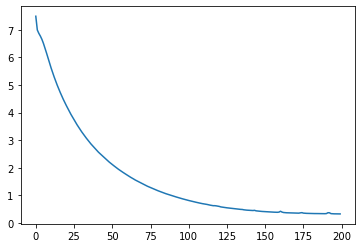

In [54]:
graphs(history)

In [60]:
df['headline'][0]

'My Beijing: The Sacred City'

In [72]:
print(sentence_generation(model, t, 'Beijing', 4))

Beijing the warriors just fine


In [66]:
df['headline'][1]

'6 Million Riders a Day, 1930s Technology'

In [69]:
print(sentence_generation(model, t, '6', 6))

6 million riders a day 1930s technology


In [70]:
df['headline'][2]

'Seeking a Cross-Border Conference'

In [71]:
print(sentence_generation(model, t, 'Seeking', 3))

Seeking a crossborder conference
